In [2]:
import sys

sys.path.append("../../functions")

from Utils import *
from Plotting import *
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
# from sklearn.linear_model import LinearRegression
# import seaborn as sns
import warnings
import seaborn
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats
from scipy.special import logsumexp
from itertools import product
from functools import partial
from multiprocessing import Pool


In [3]:
import random
import numpy as np

seed = 12
random.seed(seed)
np.random.seed(seed)


In [5]:
raw_data = pd.read_csv("../../data/twoArmedandit_with_confidence.csv")
data = raw_data[["sub", "condition", "cresp", "resp", "cj","cor", "phase", "trial", "trial_rev","reward", "Lreward", "Hreward" ]]
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

In [6]:
lv_induction_data

,sub,condition,cresp,resp,cj,cor,phase,trial,trial_rev,reward,Lreward,Hreward
0,45628,hc,0,1,1.000000,0,induction,0,19,0.595649,59.564905,62.587240
1,45628,hc,0,0,1.000000,1,induction,1,18,0.531705,51.884986,53.170477
2,45628,hc,0,1,1.000000,0,induction,2,17,0.395744,39.574438,46.393013
3,45628,hc,0,0,1.000000,1,induction,3,16,0.657494,33.232232,65.749407
4,45628,hc,0,0,3.555556,1,induction,4,15,0.750121,44.238900,75.012120
...,...,...,...,...,...,...,...,...,...,...,...,...
94736,47743,hc,1,1,5.000000,1,induction,17,4,0.727834,31.483819,72.783385
94737,47743,hc,1,1,4.037037,1,induction,18,3,0.584612,36.177430,58.461153
94738,47743,hc,1,1,1.913580,1,induction,19,2,0.590103,36.688748,59.010261
94739,47743,hc,1,1,1.195286,1,induction,20,1,0.569270,42.462693,56.926954


In [9]:
mf_df = pd.read_csv("../../results/forward_df.csv")
mf_df["bic"] = 2*mf_df["LL"] + 2*np.log(400)
mf_df["aic"] = 2*mf_df["LL"] +2*2
mf_df["neg_ll"] = mf_df["LL"]

mb_df = pd.read_csv("../../results/mb_forward_2.csv")
mb_df["bic"] = 2*mb_df["neg_ll"] + 2*np.log(400)
mb_df["aic"] = 2*mb_df["neg_ll"] + 2*2

mix_df = pd.read_csv("../../results/forward_mix_df_2.csv")
mix_df["bic"] = 2*mix_df["neg_ll"] + 5*np.log(400)
mix_df["aic"] = 2*mix_df["neg_ll"] + 5*2


<AxesSubplot:xlabel='alpha', ylabel='Count'>

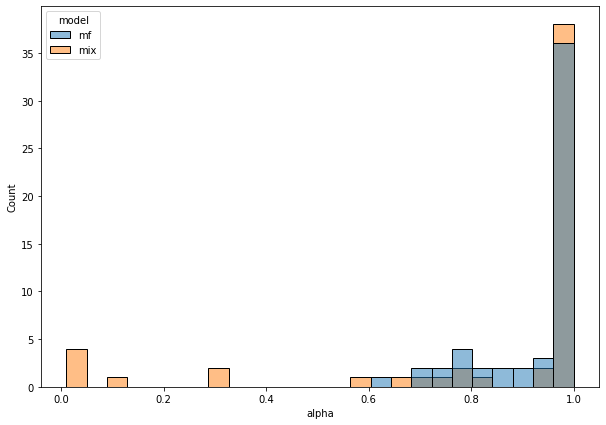

In [21]:
plt.figure(figsize=(10,7))
groups = ["mf","mix"]
merged_df = merge_result_df([mf_df, mix_df], groups, 200, subjects)

sns.histplot(merged_df, x = "alpha", hue="model")


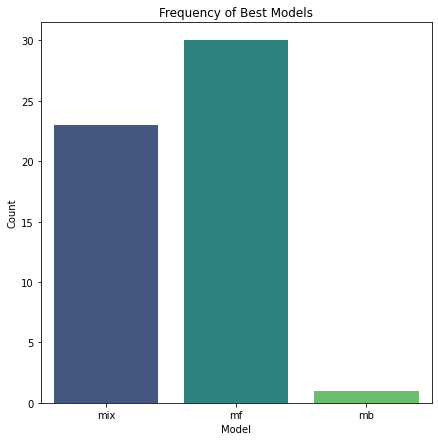

In [20]:
groups = ["mf", "mb", "mix"]
merged_df = merge_result_df([mf_df, mb_df, mix_df], groups, 200, subjects)


df_best_model = merged_df.loc[merged_df.groupby('subject')['bic'].idxmin()]
# Count the occurrences of each model
plt.figure(figsize=(7, 5))
sns.countplot(data=df_best_model, x="model", palette="viridis")

# Labels and title
plt.xlabel("Model")
plt.ylabel("Count")
plt.title("Frequency of Best Models")

# Show the plot
plt.show()

/tmp/ipykernel_291208/1603147628.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


Text(0.5, 0, 'P(mf)')

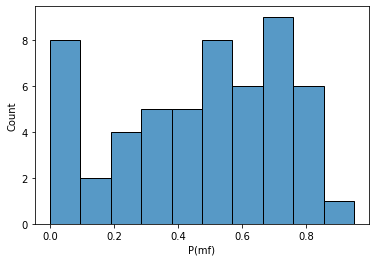

In [29]:
plt.Figure(figsize=(10,10))
mix_df_modified = mix_df.merge(df_best_model[["subject", "model"]].rename(columns={"model": "best_model"}), on ="subject")
# mix_df_modified = mix_df_modified[mix_df_modified["best_model"] == "mf"]


sns.histplot(
    mix_df_modified,
    x="gamma",
#     hue="best_model",
    bins=10,
    palette="tab10",  # or "Set2", "pastel", "deep"
    
)

plt.xlabel("P(mf)")

In [31]:
mix_df_modified.gamma.mean()

0.4717113134468639

non-paired test
Statistics for mf and emp =7.0, p=3.539e-08
Statistics for emp and mix =164.0, p=1.642e-01
Statistics for mix and mf =0.0, p=1.863e-09
mean mf = 0.77
mean emp = 0.84
mean mix = 0.83


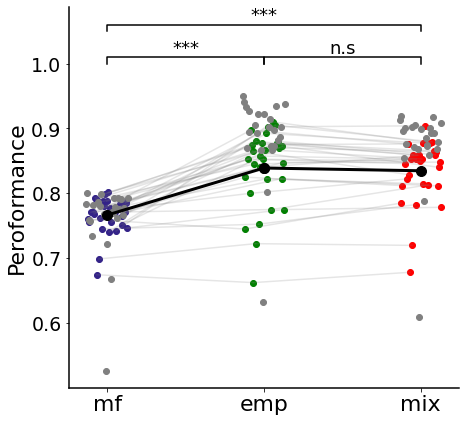

In [116]:
groups = ["mf", "emp", "mix"]
mix_sim = pd.read_csv("../../results/mix_simulation_df.csv")
mix_sim = mix_sim.rename(columns={"Subject": "subject"})

forward_sim = pd.read_csv("../../results/forward_simulation_df.csv")

subjects = lv_induction_data["sub"].unique()


forward_avg = forward_sim.groupby(["subject","run"]).mean("cor").reset_index()
forward_avg= forward_avg.groupby("subject")["cor"].mean().reset_index()[["subject","cor"]].rename(columns={"cor": "performance"})

emp_avg = lv_induction_data.groupby("sub").mean("cor").reset_index()[["sub","cor"]] \
                                                      .rename(columns={"cor": "performance","sub":"subject"})

merged_df = merge_result_df([forward_avg, emp_avg, mix_sim], groups, 200, subjects)
merged_df = merged_df.merge(df_best_model[["subject", "model"]].rename(columns={"model": "best_model"}), on ="subject")

filtered_df = merged_df[merged_df["best_model"] == "mf"]


color_dict = {"emp": "green", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(7,7))
print("non-paired test")

comparison_plot(
    filtered_df,
    "performance",
    groups,
    "",
    [["mf", "emp"], ["emp", "mix"], ["mix", "mf"]],
    [1, 1, 1.05],
    [.01, .01, .01],
    y_label="Peroformance",
    color_dict = color_dict
)


df = merged_df[merged_df["best_model"] != "mf"]
for gr in ["mf", "emp", "mix"]:
    plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                df.query("model=='{}'".format(gr))["performance"],
                label=gr, c="grey",
               alpha= 1)

non-paired test
Statistics for mf and emp =0.0, p=1.000e+00
Statistics for emp and mix =0.0, p=1.000e+00
Statistics for mix and mf =0.0, p=1.000e+00
mean mf = 0.79
mean emp = 0.85
mean mix = 0.85


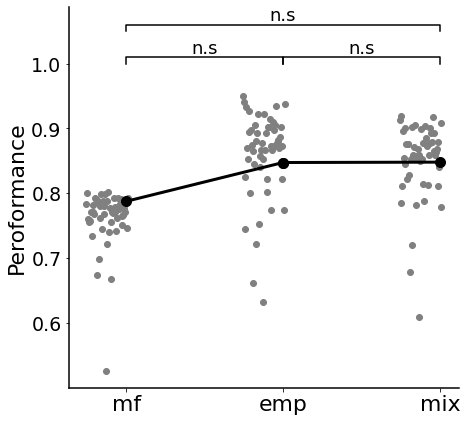

In [44]:
filtered_df = merged_df[merged_df["subject"] == 47737]


color_dict = {"emp": "green", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(7,7))
print("non-paired test")

comparison_plot(
    filtered_df,
    "performance",
    groups,
    "",
    [["mf", "emp"], ["emp", "mix"], ["mix", "mf"]],
    [1, 1, 1.05],
    [.01, .01, .01],
    y_label="Peroformance",
    color_dict = color_dict
)


df = merged_df[merged_df["subject"] != 47737]
for gr in ["mf", "emp", "mix"]:
    plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                df.query("model=='{}'".format(gr))["performance"],
                label=gr, c="grey",
               alpha= 1)

In [45]:
mf_df[mf_df["subject"] == 47737]

,Unnamed: 0,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,bic,aic,neg_ll,model,x_idx
51,51,47737,0.797108,13.766959,1.602711,0.502139,120.905848,1.477761,3.308623,253.794625,245.811696,120.905848,mf,52


In [46]:
mix_df[mix_df["subject"] == 47737]

,subject,neg_ll,gamma,alpha,beta,n,p,bic,aic,model,x_idx
51,47737,114.143699,0.391696,0.797019,11.132981,6.676,0.271333,258.24472,238.287397,mix,252


In [65]:
rewards = lv_induction_data[lv_induction_data["sub"] == 47737]["reward"].to_numpy()
resps = lv_induction_data[lv_induction_data["sub"] == 47737]["resp"].to_numpy()

In [50]:
from Forward import calculate_resps_probabilities
probs = calculate_resps_probabilities((0.797108,13.766959), resps, rewards)
ll = protected_log(probs)



<AxesSubplot:ylabel='Count'>

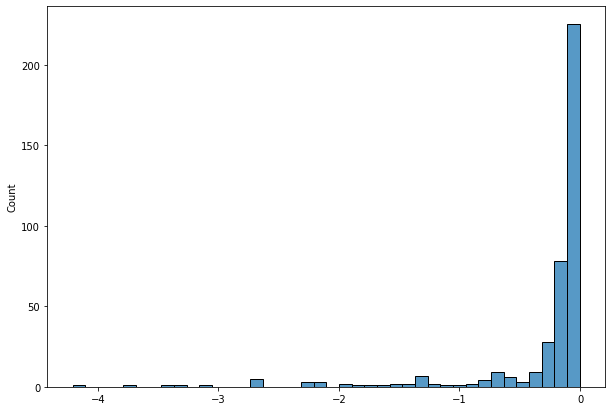

In [84]:
plt.figure(figsize=(10,7))
sns.histplot(x=ll, bins=  40)

In [113]:
## def logll
def get_states_prob_hsmm(dist_params, log_emmission_prob_seq, T, durations):
    
    D = len(durations)
    
    dist = scipy.stats.nbinom(*dist_params)
    transition_log = dist.logpmf(durations)
    transition_log = transition_log - logsumexp(transition_log)
    log_alpha = np.full((T+1, 2), -np.inf)
    log_alpha[0,:] = 1
    log_alpha[0,:] = log_alpha[0,:] - logsumexp(log_alpha[0,:])

    state_k_prob = np.zeros((T,2, D))

    for t, time in enumerate(range(1,T+1)):
        temp_d = np.zeros((2,D))
        for k, current_time in enumerate(durations):
            if current_time == 1:
                k_emmission_prob = 0
                d_emmission_prob = log_emmission_prob_seq[t,:, k]
            elif time - current_time <0 :
                k_emmission_prob = -np.inf
                d_emmission_prob = -np.inf
            else:
                k_emmission_prob = log_emmission_prob_seq[t-1,:, k-1]
                d_emmission_prob = log_emmission_prob_seq[t,:,k]

            state_k_prob[t,:,k] = k_emmission_prob + np.flip(log_alpha[time-current_time,:])
            temp_d[:,k] = d_emmission_prob + transition_log[k] + np.flip(log_alpha[time-current_time,:])
        log_alpha[time,:] = logsumexp(temp_d, axis=-1)

    state_log_probs = logsumexp(state_k_prob, axis = -1)
    sum_probs = logsumexp(state_log_probs, axis=1, keepdims=True)
    state_log_probs = state_log_probs - sum_probs
    state_probs = np.exp(state_log_probs)
    return state_probs

def sub_state_prob_hsmm(subject, data, n , p):
  
    sub_data = data[data["sub"] == subject]
    T = len(sub_data)
    rewards = sub_data["reward"].to_numpy()*100
    actions = sub_data["resp"].to_numpy()

    log_emmision_prob = np.zeros((T, 2)) # T = 1 to 400
    high_reward_dist = scipy.stats.norm(60, 8)
    low_reward_dist = scipy.stats.norm(40, 8)

    log_emmision_prob[:,0] = low_reward_dist.logpdf(rewards) # low_reward
    log_emmision_prob[:,1] = high_reward_dist.logpdf(rewards) # high_reward


    durations = range(1,71)
    D = len(durations)


    log_emmission_prob_seq = np.zeros((T,2,D)) # time from t=1 to T(400), states,durations = (1,40),

    for t, time in enumerate(range(1,T+1)):
            for d, duration in enumerate(durations):
                if t-d < 0:
                    log_emmission_prob_seq[t,:,d] = -np.inf
                else:
                    log_emmission_prob_seq[t,0,d] = np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 0]) + \
                                                    np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 1])

                    log_emmission_prob_seq[t,1,d] = np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 0]) + \
                                        np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 1])
    
    p_range = np.array([p]) 
    n_range = np.array([n])
    grid = list(product(n_range, p_range))
    
    func = partial(get_states_prob_hsmm, log_emmission_prob_seq= log_emmission_prob_seq, T = T, durations = durations)

    with Pool(128) as pool:
        results = pool.map(func, grid)

    return grid,results

In [81]:
grid,results = sub_state_prob_hsmm(47737, lv_induction_data)

In [87]:
mb_ll = protected_log(results[0][np.arange(400),resps])

<AxesSubplot:ylabel='Count'>

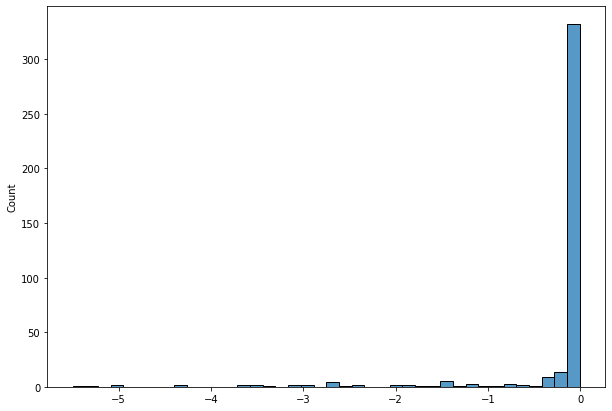

In [89]:
mb_ll
asns.histplot(x=mb_ll, bins=  40)

<AxesSubplot:xlabel='ll', ylabel='Count'>

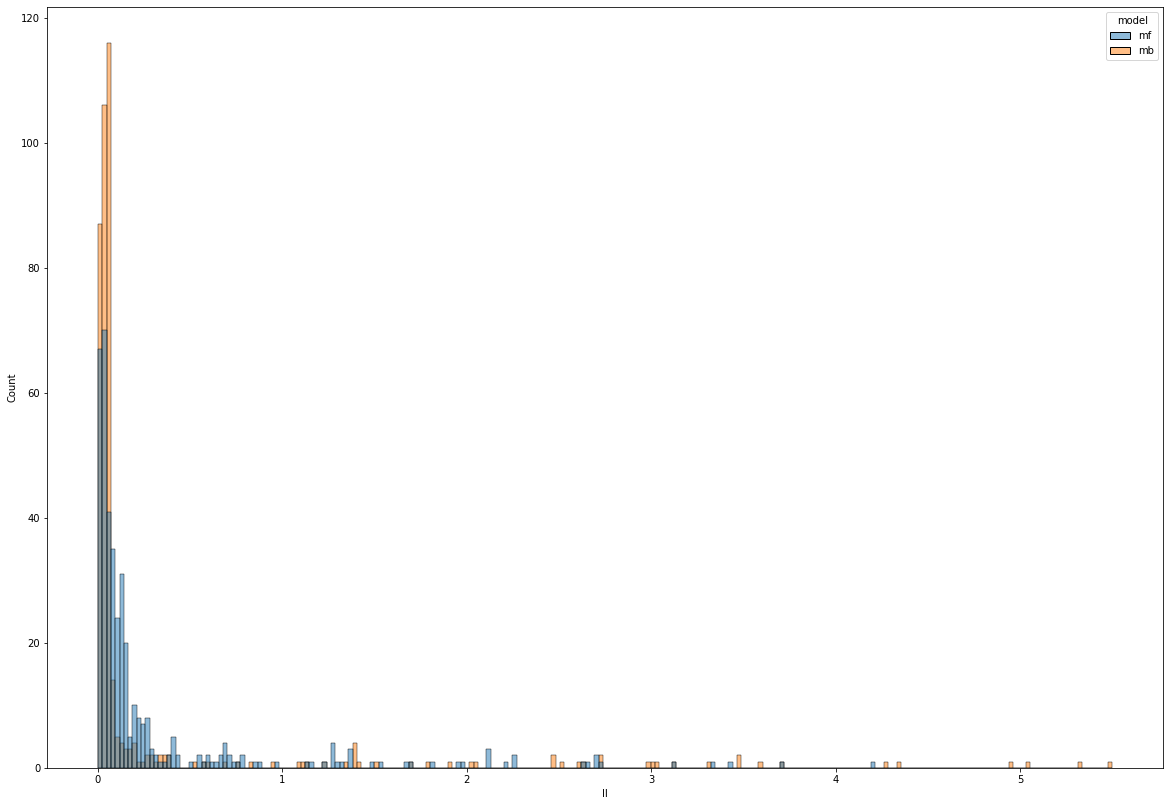

In [105]:
import numpy as np

plt.figure(figsize=(20,14))

# Creating the dataframe
data = {
    "ll": -np.concatenate((ll, mb_ll)),
    "model": np.concatenate((np.full(ll.shape, "mf"), np.full(mb_ll.shape, "mb")))
}

df = pd.DataFrame(data)

sns.histplot(df, x ="ll", hue="model")

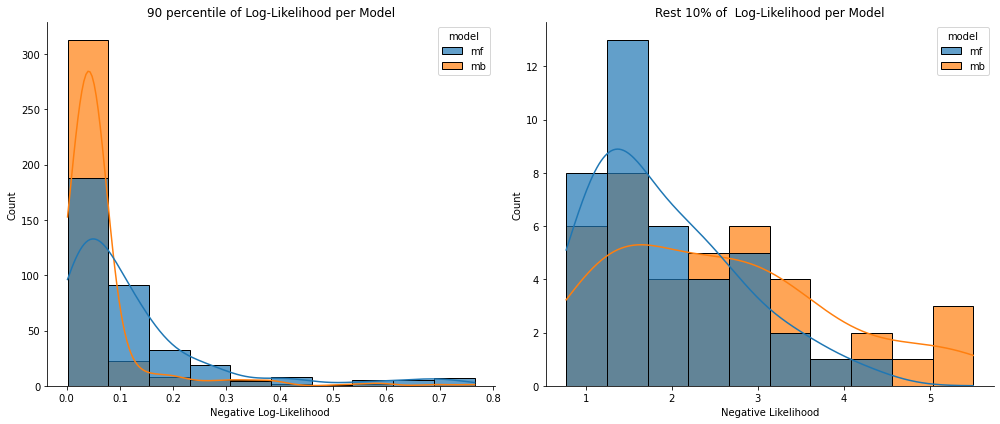

In [114]:
# Calculate the 90th percentile threshold for each model separately
threshold_mf = np.percentile(df[df["model"] == "mf"]["ll"], 90)
threshold_mb = np.percentile(df[df["model"] == "mb"]["ll"], 90)

# Filter data for the lowest 90% of values in each model category
df_filtered = df[
    ((df["model"] == "mf") & (df["ll"] <= threshold_mf)) |
    ((df["model"] == "mb") & (df["ll"] <= threshold_mb))
]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Filter data for the highest 10% of values in each model category
df_high = df[
    ((df["model"] == "mf") & (df["ll"] > threshold_mf)) |
    ((df["model"] == "mb") & (df["ll"] > threshold_mb))
]

# Plot the lowest 90% in the first subplot
sns.histplot(df_filtered, x="ll", hue="model", bins=10, kde=True, edgecolor='black', alpha=0.7, ax=axes[0])
axes[0].set_xlabel("Negative Log-Likelihood ")
axes[0].set_ylabel("Count")
axes[0].set_title("90 percentile of Log-Likelihood per Model")

# Plot the highest 10% in the second subplot
sns.histplot(df_high, x="ll", hue="model", bins=10, kde=True, edgecolor='black', alpha=0.7, ax=axes[1])
axes[1].set_xlabel("Negative Likelihood")
axes[1].set_ylabel("Count")
axes[1].set_title("Rest 10% of  Log-Likelihood per Model")

# Show the plot
sns.despine()
plt.tight_layout()
plt.show()


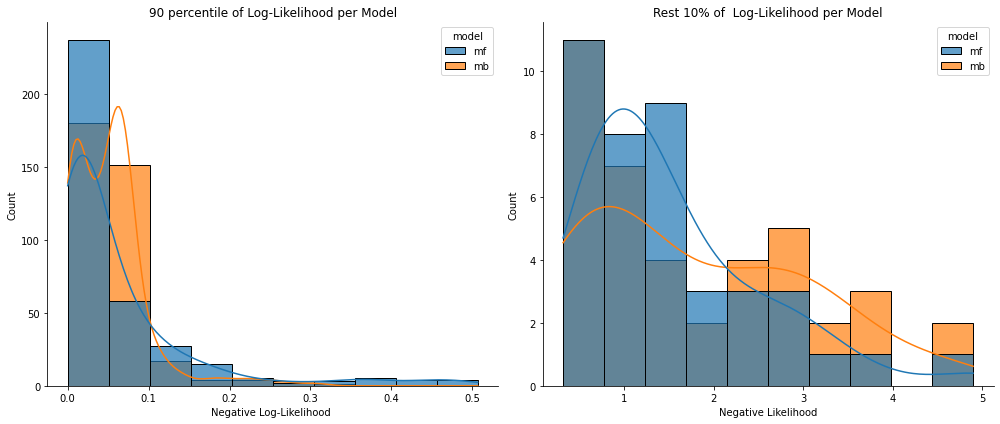

In [127]:
subject = 46057
rewards = lv_induction_data[lv_induction_data["sub"] == subject]["reward"].to_numpy()
resps = lv_induction_data[lv_induction_data["sub"] == subject]["resp"].to_numpy()

grid,results = sub_state_prob_hsmm(subject, lv_induction_data, mix_df[mix_df["subject"] == subject].iloc[0]["n"], 
                                  mix_df[mix_df["subject"] == subject].iloc[0]["p"])
mb_ll = protected_log(results[0][np.arange(400),resps])
probs = calculate_resps_probabilities((mf_df[mf_df["subject"] == 46057].iloc[0]["alpha"],
                                      mf_df[mf_df["subject"] == 46057].iloc[0]["beta"]), resps, rewards)
ll = protected_log(probs)


# Creating the dataframe
data = {
    "ll": -np.concatenate((ll, mb_ll)),
    "model": np.concatenate((np.full(ll.shape, "mf"), np.full(mb_ll.shape, "mb")))
}

df = pd.DataFrame(data)

# Calculate the 90th percentile threshold for each model separately
threshold_mf = np.percentile(df[df["model"] == "mf"]["ll"], 90)
threshold_mb = np.percentile(df[df["model"] == "mb"]["ll"], 90)

# Filter data for the lowest 90% of values in each model category
df_filtered = df[
    ((df["model"] == "mf") & (df["ll"] <= threshold_mf)) |
    ((df["model"] == "mb") & (df["ll"] <= threshold_mb))
]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Filter data for the highest 10% of values in each model category
df_high = df[
    ((df["model"] == "mf") & (df["ll"] > threshold_mf)) |
    ((df["model"] == "mb") & (df["ll"] > threshold_mb))
]

# Plot the lowest 90% in the first subplot
sns.histplot(df_filtered, x="ll", hue="model", bins=10, kde=True, edgecolor='black', alpha=0.7, ax=axes[0])
axes[0].set_xlabel("Negative Log-Likelihood ")
axes[0].set_ylabel("Count")
axes[0].set_title("90 percentile of Log-Likelihood per Model")

# Plot the highest 10% in the second subplot
sns.histplot(df_high, x="ll", hue="model", bins=10, kde=True, edgecolor='black', alpha=0.7, ax=axes[1])
axes[1].set_xlabel("Negative Likelihood")
axes[1].set_ylabel("Count")
axes[1].set_title("Rest 10% of  Log-Likelihood per Model")

# Show the plot
sns.despine()
plt.tight_layout()
plt.show()




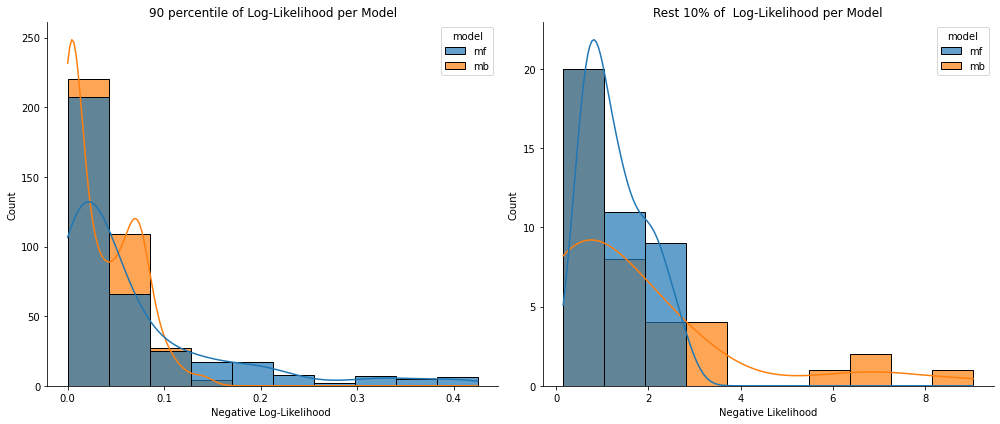

In [130]:
subject = 46024
rewards = lv_induction_data[lv_induction_data["sub"] == subject]["reward"].to_numpy()
resps = lv_induction_data[lv_induction_data["sub"] == subject]["resp"].to_numpy()

grid,results = sub_state_prob_hsmm(subject, lv_induction_data, mix_df[mix_df["subject"] == subject].iloc[0]["n"], 
                                  mix_df[mix_df["subject"] == subject].iloc[0]["p"])
mb_ll = protected_log(results[0][np.arange(400),resps])
probs = calculate_resps_probabilities((mf_df[mf_df["subject"] == 46057].iloc[0]["alpha"],
                                      mf_df[mf_df["subject"] == 46057].iloc[0]["beta"]), resps, rewards)
ll = protected_log(probs)


# Creating the dataframe
data = {
    "ll": -np.concatenate((ll, mb_ll)),
    "model": np.concatenate((np.full(ll.shape, "mf"), np.full(mb_ll.shape, "mb")))
}

df = pd.DataFrame(data)

# Calculate the 90th percentile threshold for each model separately
threshold_mf = np.percentile(df[df["model"] == "mf"]["ll"], 90)
threshold_mb = np.percentile(df[df["model"] == "mb"]["ll"], 90)

# Filter data for the lowest 90% of values in each model category
df_filtered = df[
    ((df["model"] == "mf") & (df["ll"] <= threshold_mf)) |
    ((df["model"] == "mb") & (df["ll"] <= threshold_mb))
]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Filter data for the highest 10% of values in each model category
df_high = df[
    ((df["model"] == "mf") & (df["ll"] > threshold_mf)) |
    ((df["model"] == "mb") & (df["ll"] > threshold_mb))
]

# Plot the lowest 90% in the first subplot
sns.histplot(df_filtered, x="ll", hue="model", bins=10, kde=True, edgecolor='black', alpha=0.7, ax=axes[0])
axes[0].set_xlabel("Negative Log-Likelihood ")
axes[0].set_ylabel("Count")
axes[0].set_title("90 percentile of Log-Likelihood per Model")

# Plot the highest 10% in the second subplot
sns.histplot(df_high, x="ll", hue="model", bins=10, kde=True, edgecolor='black', alpha=0.7, ax=axes[1])
axes[1].set_xlabel("Negative Likelihood")
axes[1].set_ylabel("Count")
axes[1].set_title("Rest 10% of  Log-Likelihood per Model")

# Show the plot
sns.despine()
plt.tight_layout()
plt.show()




In [129]:
filtered_df[:30]

,subject,performance,model,x_idx,best_model
6,45664,0.760300,mf,3,mf
7,45664,0.745000,emp,203,mf
8,45664,0.785100,mix,403,mf
9,45682,0.756550,mf,4,mf
10,45682,0.825000,emp,204,mf
11,45682,0.811875,mix,404,mf
18,45763,0.770825,mf,7,mf
19,45763,0.852500,emp,207,mf
20,45763,0.845900,mix,407,mf
27,45964,0.771150,mf,10,mf


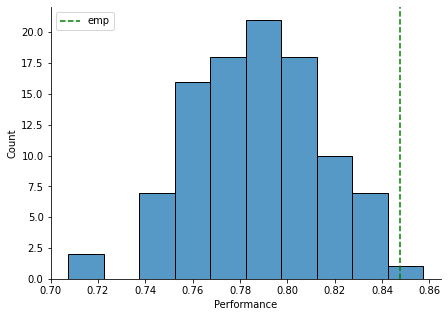

In [151]:
forward_avg = forward_sim.groupby(["subject","run"]).mean("cor").reset_index()
# forward_avg= forward_avg.groupby("subject")["cor"].mean().reset_index()[["subject","cor"]].rename(columns={"cor": "performance"})
sub_data = forward_avg[forward_avg["subject"] == 47737]

plt.figure(figsize=(7,5))
sns.histplot(sub_data, x ="cor")
plt.axvline(x = 0.8475, c = "green", ls ="--", label = "emp")
plt.xlabel("Performance")
sns.despine()
plt.legend()
plt.show()



In [146]:
emp_avg[emp_avg["subject"] == 47737]


,subject,performance,model,x_idx
51,47737,0.8475,emp,252
